In [1]:
# M3-1: Setup & sanity check (paths, logs, inventory)

from pathlib import Path
import pandas as pd
import json, re

# ---------- project paths ----------
PROJECT      = Path("/scratch/qin.yife/Generative_Project")
REAL_DIR     = PROJECT / "data" / "processed" / "images"           # Flickr30k cleaned images
M2_FULL_DIR  = PROJECT / "outputs" / "m2_full" / "images"          # sampler × CFG sweep (48 imgs expected)
M2_STEPS_DIR = PROJECT / "outputs" / "m2_full_steps" / "images"    # steps sweep set
METRICS_DIR  = PROJECT / "metrics"; METRICS_DIR.mkdir(exist_ok=True, parents=True)
OUT_M3_DIR   = PROJECT / "outputs" / "m3"; OUT_M3_DIR.mkdir(exist_ok=True, parents=True)

LOG_FULL_CSV  = METRICS_DIR / "m2_full_runs.csv"
LOG_STEPS_CSV = METRICS_DIR / "m2_steps_runs.csv"

PLAN_JSON     = OUT_M3_DIR / "plan.json"   # record what we will evaluate

# ---------- load logs (tolerant reader) ----------
def read_log(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        return pd.DataFrame()
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        # tolerate ragged rows
        df = pd.read_csv(csv_path, engine="python")
    # normalize columns we care about
    keep = ["prompt_id","prompt","prompt_slug","scheduler","guidance_scale","steps","seed",
            "negative_prompt","file","model"]
    for c in keep:
        if c not in df.columns:
            df[c] = ""
    # drop rows without file
    df["file"] = df["file"].astype(str).str.strip()
    df = df[df["file"]!=""].copy()
    return df[keep]

df_full  = read_log(LOG_FULL_CSV)
df_steps = read_log(LOG_STEPS_CSV)

# combine and keep only existing files
df_gen = pd.concat([df_full, df_steps], ignore_index=True)
df_gen["exists"] = df_gen["file"].apply(lambda s: Path(s).exists())
df_gen = df_gen[df_gen["exists"]].drop(columns=["exists"]).drop_duplicates(subset=["file"]).reset_index(drop=True)

# try to coerce numeric types
for col in ["guidance_scale","steps","seed"]:
    df_gen[col] = pd.to_numeric(df_gen[col], errors="coerce")

# simple slug for grouping
def slugify(text: str, max_len: int = 48):
    t = re.sub(r"[^A-Za-z0-9\s\-]+", "", str(text)).strip()
    t = re.sub(r"\s+", " ", t)
    slug = t.lower().replace(" ", "-")
    return (slug[:max_len].rstrip("-") or "prompt")

df_gen["prompt_slug"] = df_gen["prompt_slug"].where(df_gen["prompt_slug"].astype(str).str.len()>0,
                                                    df_gen["prompt"].apply(slugify))

# ---------- inventory ----------
real_images = sorted([p for p in REAL_DIR.glob("*.jpg")] + [p for p in REAL_DIR.glob("*.png")])
gen_images  = df_gen["file"].tolist()

# quick breakdowns
by_sched = df_gen.groupby("scheduler")["file"].count().sort_values(ascending=False)
by_cfg   = df_gen.groupby("guidance_scale")["file"].count().sort_values(ascending=False)
by_steps = df_gen.groupby("steps")["file"].count().sort_values(ascending=False)
by_pid   = df_gen.groupby("prompt_id")["file"].count().sort_values(ascending=True)

# ---------- save evaluation plan ----------
plan = {
    "real_dir": str(REAL_DIR),
    "num_real_candidates": len(real_images),
    "generated_total": len(gen_images),
    "breakdown": {
        "scheduler": by_sched.to_dict(),
        "cfg": {str(k): int(v) for k,v in by_cfg.to_dict().items()},
        "steps": {str(k): int(v) for k,v in by_steps.to_dict().items()},
        "per_prompt_id": {str(k): int(v) for k,v in by_pid.to_dict().items()},
    },
    "logs": {
        "m2_full_runs_csv": str(LOG_FULL_CSV),
        "m2_steps_runs_csv": str(LOG_STEPS_CSV)
    },
    "outputs": {
        "m3_dir": str(OUT_M3_DIR)
    }
}
PLAN_JSON.write_text(json.dumps(plan, indent=2))

# ---------- print summary ----------
print("=== M3 Setup — Inventory ===")
print("Real images dir  :", REAL_DIR, "| found:", len(real_images))
print("Generated images :", len(gen_images))
print("\nBreakdown by scheduler:\n", by_sched.to_string())
print("\nBreakdown by CFG:\n", by_cfg.to_string())
print("\nBreakdown by steps:\n", by_steps.to_string())
print("\nPer-prompt counts:\n", by_pid.to_string())
print("\nPlan saved ->", PLAN_JSON)
print("\nNEXT: compute reference features for FID on a subset of real images,")
print("      then compute FID & Inception Score on generated images,")
print("      and CLIP text–image alignment per image (grouped by settings).")

/tmp/ipykernel_2324021/41585715.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_gen = pd.concat([df_full, df_steps], ignore_index=True)


=== M3 Setup — Inventory ===
Real images dir  : /scratch/qin.yife/Generative_Project/data/processed/images | found: 5000
Generated images : 24

Breakdown by scheduler:
 scheduler
DPMSolver    24

Breakdown by CFG:
 guidance_scale
7.0    24

Breakdown by steps:
 steps
20    8
28    8
36    8

Per-prompt counts:
 prompt_id
1    3
2    3
3    3
4    3
5    3
6    3
7    3
8    3

Plan saved -> /scratch/qin.yife/Generative_Project/outputs/m3/plan.json

NEXT: compute reference features for FID on a subset of real images,
      then compute FID & Inception Score on generated images,
      and CLIP text–image alignment per image (grouped by settings).


In [3]:
# M3-2B: InceptionV3 features for REAL images (FID reference) — fixed aux_logits handling

from pathlib import Path
import numpy as np
import torch
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import random, time

PROJECT   = Path("/scratch/qin.yife/Generative_Project")
REAL_DIR  = PROJECT / "data" / "processed" / "images"
OUT_DIR   = PROJECT / "outputs" / "m3"; OUT_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = OUT_DIR / "cache"; CACHE_DIR.mkdir(parents=True, exist_ok=True)

# ---- configurable (CPU-safe defaults) ----
N_REAL     = 1000              # number of real images to sample as FID reference
SEED       = 20251122
BATCH      = 16
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

# ---- list & sample real images ----
real_paths = sorted([p for p in REAL_DIR.glob("*.jpg")] + [p for p in REAL_DIR.glob("*.png")])
assert len(real_paths) > 0, f"No images found in {REAL_DIR}"

random.seed(SEED)
picked = random.sample(real_paths, N_REAL) if len(real_paths) >= N_REAL else real_paths

# ---- cache key ----
cache_key  = f"inception_real_n{len(picked)}_seed{SEED}.npz"
cache_path = CACHE_DIR / cache_key

if cache_path.exists():
    data   = np.load(cache_path)
    feats  = data["features"]     # [K, 2048]
    files  = data["files"]
    print(f"[CACHE] Loaded real features from {cache_path} | shape: {feats.shape}")
else:
    # ---- model & preprocessing ----
    weights = Inception_V3_Weights.IMAGENET1K_V1
    # IMPORTANT: do NOT set aux_logits=False when using pretrained weights
    model = inception_v3(weights=weights).to(DEVICE).eval()
    # grab the global average pool output (2048-d)
    feat_extractor = create_feature_extractor(model, return_nodes={"avgpool": "pool"})
    # official transforms (handles resize/crop/normalize for Inception v3)
    preprocess = weights.transforms()

    def load_tensor(path: Path):
        im = Image.open(path).convert("RGB")
        return preprocess(im)  # returns a tensor ready for the model

    feats_list, files = [], []
    t0 = time.time()
    for i in range(0, len(picked), BATCH):
        batch_paths = picked[i:i+BATCH]
        batch = torch.stack([load_tensor(p) for p in batch_paths], dim=0).to(DEVICE)
        with torch.no_grad():
            out = feat_extractor(batch)["pool"]    # [B, 2048, 1, 1]
            f = torch.flatten(out, 1).cpu().numpy()
        feats_list.append(f)
        files.extend([str(p) for p in batch_paths])
        print(f"\rExtracting features: {min(i+BATCH,len(picked))}/{len(picked)}", end="")
    feats = np.concatenate(feats_list, axis=0)
    print(f"\nDone in {time.time()-t0:.1f}s. Features shape: {feats.shape}")

    # save cache
    np.savez_compressed(cache_path, features=feats, files=np.array(files))
    print("Saved cache ->", cache_path)

# ---- compute and save FID reference stats ----
mu_real    = feats.mean(axis=0)
sigma_real = np.cov(feats, rowvar=False)
stats_path = CACHE_DIR / f"fid_stats_real_n{feats.shape[0]}_seed{SEED}.npz"
np.savez_compressed(stats_path, mu=mu_real, sigma=sigma_real, files=np.array(files))
print("Saved FID reference stats ->", stats_path)

print("\nSummary:")
print("Real set used  :", len(files))
print("Feature dim    :", feats.shape[1])
print("Device         :", DEVICE)
print("Next step      : compute generated features group-wise and then FID / Inception Score.")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/qin.yife/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:02<00:00, 49.5MB/s] 
/home/qin.yife/.local/lib/python3.12/site-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


Extracting features: 1000/1000
Done in 25.2s. Features shape: (1000, 2048)
Saved cache -> /scratch/qin.yife/Generative_Project/outputs/m3/cache/inception_real_n1000_seed20251122.npz
Saved FID reference stats -> /scratch/qin.yife/Generative_Project/outputs/m3/cache/fid_stats_real_n1000_seed20251122.npz

Summary:
Real set used  : 1000
Feature dim    : 2048
Device         : cpu
Next step      : compute generated features group-wise and then FID / Inception Score.


In [4]:
# M3-3: Compute features for GENERATED images and evaluate FID + Inception Score (grouped by steps)

from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import csv, time
# we try to use scipy for matrix sqrt; if unavailable, fall back to eigen method
try:
    from scipy import linalg as sla
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# ---------- Paths ----------
PROJECT      = Path("/scratch/qin.yife/Generative_Project")
REAL_STATS   = PROJECT / "outputs" / "m3" / "cache" / "fid_stats_real_n1000_seed20251122.npz"
LOG_FULL_CSV = PROJECT / "metrics" / "m2_full_runs.csv"
LOG_STEPS_CSV= PROJECT / "metrics" / "m2_steps_runs.csv"
OUT_METRICS  = PROJECT / "metrics" / "m3_scores.csv"

assert REAL_STATS.exists(), f"Real FID stats not found: {REAL_STATS}"

# ---------- Load generation logs and filter the steps-sweep set ----------
def read_log(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        return pd.DataFrame()
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        df = pd.read_csv(csv_path, engine="python")
    for c in ["prompt_id","prompt","scheduler","guidance_scale","steps","file"]:
        if c not in df.columns: df[c] = ""
    df["file"] = df["file"].astype(str).str.strip()
    df = df[df["file"]!=""].copy()
    # numeric
    for c in ["guidance_scale","steps"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

df_full  = read_log(LOG_FULL_CSV)
df_steps = read_log(LOG_STEPS_CSV)

# keep only DPMSolver steps sweep (20/28/36); adjust here if you want to add other groups
df = df_steps.copy()
df = df[df["scheduler"]=="DPMSolver"]
df = df[df["steps"].isin([20,28,36])]
df = df[df["file"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

assert len(df)>0, "No generated images found for steps sweep."

print("Generated images found:", len(df))
print(df.groupby("steps")["file"].count().to_string())

# ---------- InceptionV3 models: one for features (avgpool), one for logits (IS) ----------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
weights = Inception_V3_Weights.IMAGENET1K_V1

# feature extractor for FID (2048-d from avgpool)
feat_model = inception_v3(weights=weights).to(DEVICE).eval()
feat_extractor = create_feature_extractor(feat_model, return_nodes={"avgpool":"pool"})
preprocess = weights.transforms()

# classifier for Inception Score (we can reuse the same backbone; just forward to logits)
# We'll reuse feat_model; to get logits we call the original model forward.
cls_model = feat_model  # same weights

def load_tensor(path: Path):
    im = Image.open(path).convert("RGB")
    return preprocess(im)

# ---------- Helpers ----------
def inception_features(img_paths, batch_size=16):
    feats = []
    t0 = time.time()
    for i in range(0, len(img_paths), batch_size):
        batch_paths = img_paths[i:i+batch_size]
        batch = torch.stack([load_tensor(Path(p)) for p in batch_paths], dim=0).to(DEVICE)
        with torch.no_grad():
            out = feat_extractor(batch)["pool"]  # [B, 2048, 1, 1]
            f = torch.flatten(out, 1).cpu().numpy()
        feats.append(f)
        print(f"\r[FEATS] {min(i+batch_size,len(img_paths))}/{len(img_paths)}", end="")
    feats = np.concatenate(feats, axis=0)
    print(f"\n[FEATS] Done in {time.time()-t0:.1f}s | shape {feats.shape}")
    return feats

def inception_probs(img_paths, batch_size=16):
    probs = []
    t0 = time.time()
    for i in range(0, len(img_paths), batch_size):
        batch_paths = img_paths[i:i+batch_size]
        batch = torch.stack([load_tensor(Path(p)) for p in batch_paths], dim=0).to(DEVICE)
        with torch.no_grad():
            logits = cls_model(batch)  # [B, 1000]
            p = torch.softmax(logits, dim=1).cpu().numpy()
        probs.append(p)
        print(f"\r[IS] {min(i+batch_size,len(img_paths))}/{len(img_paths)}", end="")
    probs = np.concatenate(probs, axis=0)
    print(f"\n[IS] Done in {time.time()-t0:.1f}s | shape {probs.shape}")
    return probs

def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # Compute Fréchet distance between two Gaussians
    # ||mu1-mu2||^2 + Tr(sigma1 + sigma2 - 2*sqrt(sigma1 sigma2))
    diff = mu1 - mu2
    diff_sq = diff.dot(diff)
    if SCIPY_OK:
        covmean = sla.sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
    else:
        # Eigen fallback on the symmetric product (stabilized)
        A = sigma1 @ sigma2
        # symmetrize to reduce numerical issues
        A = (A + A.T) / 2.0
        eigvals, eigvecs = np.linalg.eigh(A)
        eigvals = np.clip(eigvals, a_min=0.0, a_max=None)
        covmean = (eigvecs * np.sqrt(eigvals)) @ eigvecs.T
    tr = np.trace(sigma1) + np.trace(sigma2) - 2.0 * np.trace(covmean)
    return float(diff_sq + tr)

def inception_score(probs, splits=1):
    # Standard IS: exp( E_x [ KL( p(y|x) || p(y) ) ] )
    # Optionally average over splits; here dataset is small, splits=1
    scores = []
    N = probs.shape[0]
    for k in range(splits):
        part = probs[k * (N//splits):(k+1) * (N//splits)]
        p_y = part.mean(axis=0, keepdims=True)
        kl = part * (np.log(part + 1e-8) - np.log(p_y + 1e-8))
        kl_mean = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl_mean))
    return float(np.mean(scores)), float(np.std(scores))

# ---------- Load real stats ----------
real = np.load(REAL_STATS)
mu_real, sigma_real = real["mu"], real["sigma"]
assert mu_real.shape[0] == 2048, "Unexpected real feature dim"

# ---------- Evaluate by group (steps) ----------
results = []
for steps, g in df.groupby("steps"):
    paths = g["file"].tolist()
    print(f"\n=== Evaluating group: steps={steps} | n={len(paths)} ===")
    feats = inception_features(paths, batch_size=16)
    mu_gen = feats.mean(axis=0)
    sigma_gen = np.cov(feats, rowvar=False)
    fid = frechet_distance(mu_gen, sigma_gen, mu_real, sigma_real)

    probs = inception_probs(paths, batch_size=16)
    is_mean, is_std = inception_score(probs, splits=1)

    results.append({
        "group": f"steps={int(steps)}",
        "n_images": len(paths),
        "FID_vs_real1000": fid,
        "IS_mean": is_mean,
        "IS_std": is_std
    })

# ---------- Save and display ----------
res_df = pd.DataFrame(results).sort_values("group").reset_index(drop=True)
print("\n=== M3 — FID & IS (by steps) ===")
print(res_df.to_string(index=False, justify="center", col_space=12, formatters={
    "FID_vs_real1000": lambda x: f"{x:.2f}",
    "IS_mean": lambda x: f"{x:.3f}",
    "IS_std": lambda x: f"{x:.3f}",
}))
res_df.to_csv(OUT_METRICS, index=False)
print("\nSaved metrics ->", OUT_METRICS)
print("\nNEXT: we will compute CLIP text–image alignment per image and aggregate by group, "
      "then produce tables and simple plots.")

Generated images found: 24
steps
20    8
28    8
36    8


/home/qin.yife/.local/lib/python3.12/site-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)



=== Evaluating group: steps=20 | n=8 ===
[FEATS] 8/8
[FEATS] Done in 0.3s | shape (8, 2048)
[IS] 8/8
[IS] Done in 0.4s | shape (8, 1000)

=== Evaluating group: steps=28 | n=8 ===
[FEATS] 8/8
[FEATS] Done in 0.3s | shape (8, 2048)
[IS] 8/8
[IS] Done in 0.4s | shape (8, 1000)

=== Evaluating group: steps=36 | n=8 ===
[FEATS] 8/8
[FEATS] Done in 0.3s | shape (8, 2048)
[IS] 8/8
[IS] Done in 0.4s | shape (8, 1000)

=== M3 — FID & IS (by steps) ===
   group       n_images   FID_vs_real1000   IS_mean       IS_std   
  steps=20        8            358.17        5.996        0.000    
  steps=28        8            373.76        6.326        0.000    
  steps=36        8            379.25        6.826        0.000    

Saved metrics -> /scratch/qin.yife/Generative_Project/metrics/m3_scores.csv

NEXT: we will compute CLIP text–image alignment per image and aggregate by group, then produce tables and simple plots.


Loaded generated set: 24 rows
steps
20    8
28    8
36    8 



config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/home/qin.yife/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Encoding group steps=20 | n=8
Encoding group steps=28 | n=8
Encoding group steps=36 | n=8

=== CLIP text–image alignment (by steps) ===
   steps        n     clip_mean   clip_std 
    20         8        0.312      0.026   
    28         8        0.306      0.029   
    36         8        0.308      0.027   

Saved CLIP scores -> /scratch/qin.yife/Generative_Project/metrics/m3_clip_scores.csv


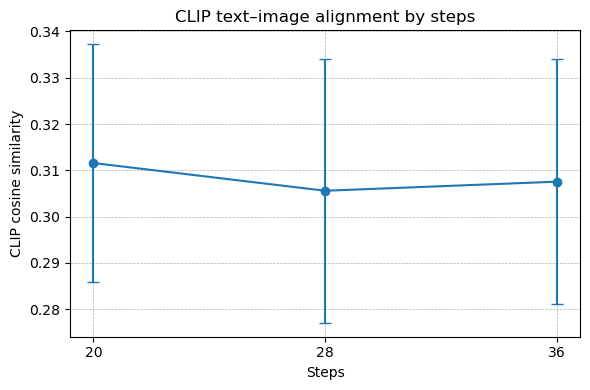

Saved plot -> /scratch/qin.yife/Generative_Project/outputs/m3/clip_alignment_by_steps.png


In [5]:
# M3-4: CLIP text–image alignment grouped by sampling steps
# - Reads your m2_steps_runs.csv
# - Uses CLIP ViT-B/32 to encode text and images
# - Computes cosine similarity per pair, then aggregates by steps
# - Saves table to metrics/m3_clip_scores.csv and a bar plot to outputs/m3/clip_alignment_by_steps.png

import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import torch
from tqdm import trange
import matplotlib.pyplot as plt

# Avoid hf_transfer requirement issues on this cluster
os.environ.setdefault("HF_HUB_ENABLE_HF_TRANSFER", "0")

from transformers import CLIPProcessor, CLIPModel

# ---------- Paths ----------
PROJECT       = Path("/scratch/qin.yife/Generative_Project")
LOG_STEPS_CSV = PROJECT / "metrics" / "m2_steps_runs.csv"
OUT_METRICS   = PROJECT / "metrics" / "m3_clip_scores.csv"
OUT_DIR       = PROJECT / "outputs" / "m3"; OUT_DIR.mkdir(parents=True, exist_ok=True)
PLOT_PATH     = OUT_DIR / "clip_alignment_by_steps.png"

# ---------- Load steps-sweep log ----------
def read_log(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(f"Log not found: {csv_path}")
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        df = pd.read_csv(csv_path, engine="python")
    for c in ["prompt_id","prompt","scheduler","guidance_scale","steps","file"]:
        if c not in df.columns: df[c] = ""
    df["file"] = df["file"].astype(str).str.strip()
    df = df[(df["file"]!="") & (df["scheduler"]=="DPMSolver") & (df["steps"].isin([20,28,36]))].copy()
    df["steps"] = pd.to_numeric(df["steps"], errors="coerce")
    df = df[df["file"].apply(lambda p: Path(p).exists())].reset_index(drop=True)
    return df

df = read_log(LOG_STEPS_CSV)
assert len(df) > 0, "No generated images found for DPMSolver steps sweep."
print("Loaded generated set:", len(df), "rows")
print(df.groupby("steps")["file"].count().to_string(), "\n")

# ---------- CLIP model ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id).to(device).eval()
processor = CLIPProcessor.from_pretrained(model_id)

# ---------- Helpers ----------
def encode_texts(texts, batch_size=16):
    feats = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            t = model.get_text_features(**inputs)  # [B, D]
            t = torch.nn.functional.normalize(t, dim=1)
        feats.append(t.cpu())
    return torch.cat(feats, dim=0)  # [N, D]

def encode_images(paths, batch_size=16):
    feats = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i+batch_size]
        images = [Image.open(p).convert("RGB") for p in batch_paths]
        inputs = processor(images=images, return_tensors="pt").to(device)
        with torch.no_grad():
            v = model.get_image_features(**inputs)  # [B, D]
            v = torch.nn.functional.normalize(v, dim=1)
        feats.append(v.cpu())
        # close PIL images to free handles
        for im in images:
            im.close()
    return torch.cat(feats, dim=0)  # [N, D]

# Compute per-row cosine similarities
rows = []
for steps, g in df.groupby("steps"):
    g = g.reset_index(drop=True)
    texts = g["prompt"].tolist()
    paths = g["file"].tolist()
    print(f"Encoding group steps={int(steps)} | n={len(paths)}")

    t_feats = encode_texts(texts, batch_size=16)   # [N, D]
    v_feats = encode_images(paths, batch_size=8)   # [N, D] (images heavier, smaller batch)

    sims = (t_feats * v_feats).sum(dim=1).numpy()  # cosine since features already normalized
    for i, s in enumerate(sims):
        rows.append({
            "steps": int(steps),
            "prompt_id": g.loc[i, "prompt_id"],
            "file": g.loc[i, "file"],
            "clip_cosine": float(s)
        })

df_clip = pd.DataFrame(rows).sort_values(["steps","prompt_id"]).reset_index(drop=True)

# Aggregate by steps
agg = df_clip.groupby("steps")["clip_cosine"].agg(["count","mean","std"]).reset_index()
agg = agg.rename(columns={"count":"n", "mean":"clip_mean", "std":"clip_std"})
print("\n=== CLIP text–image alignment (by steps) ===")
print(agg.to_string(index=False, justify="center", col_space=10, formatters={
    "clip_mean": lambda x: f"{x:.3f}",
    "clip_std":  lambda x: f"{x:.3f}",
}))

# Save CSV
agg.to_csv(OUT_METRICS, index=False)
print("\nSaved CLIP scores ->", OUT_METRICS)

# Plot: mean with error bars (std)
fig = plt.figure(figsize=(6,4))
x = agg["steps"].astype(int).tolist()
y = agg["clip_mean"].tolist()
e = agg["clip_std"].fillna(0.0).tolist()
plt.errorbar(x, y, yerr=e, fmt="o-", capsize=4)
plt.title("CLIP text–image alignment by steps")
plt.xlabel("Steps")
plt.ylabel("CLIP cosine similarity")
plt.xticks(x)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=150)
plt.show()

print("Saved plot ->", PLOT_PATH)

=== M3 — Combined metrics (by steps) ===
 steps  n_images    FID IS_mean IS_std  clip_n CLIP_mean CLIP_std
    20         8 358.17   5.996  0.000       8     0.312    0.026
    28         8 373.76   6.326  0.000       8     0.306    0.029
    36         8 379.25   6.826  0.000       8     0.308    0.027

Saved combined table -> /scratch/qin.yife/Generative_Project/metrics/m3_all_scores.csv


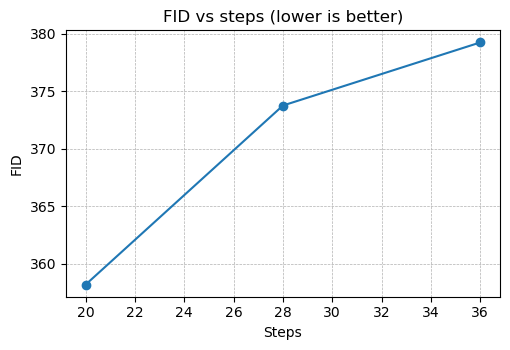

Saved plot -> /scratch/qin.yife/Generative_Project/outputs/m3/fid_by_steps.png


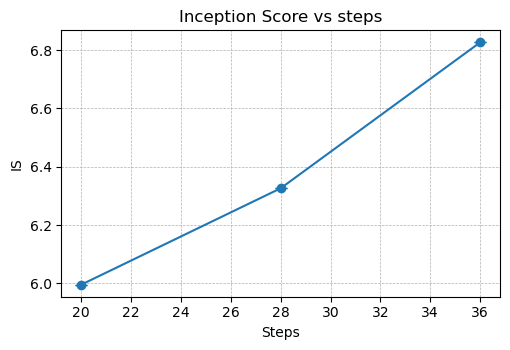

Saved plot -> /scratch/qin.yife/Generative_Project/outputs/m3/is_by_steps.png


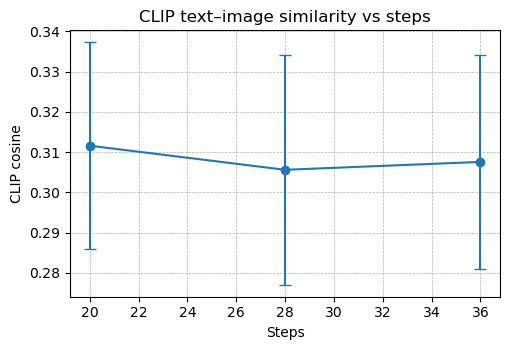

Saved plot -> /scratch/qin.yife/Generative_Project/outputs/m3/clip_by_steps.png

Wrote summary -> /scratch/qin.yife/Generative_Project/outputs/m3/m3_eval_summary.md

NEXT: If you want, we can extend M3 to add a guidance-scale sensitivity sweep (e.g., CFG 5 / 7.5 / 10) and include a second table and plots; or proceed to assemble the Evaluation Notebook section for your report.


In [6]:
# M3-5: Merge FID, Inception Score, and CLIP alignment (by steps)
# - Inputs : metrics/m3_scores.csv  (FID & IS)
#            metrics/m3_clip_scores.csv (CLIP)
# - Outputs: metrics/m3_all_scores.csv
#            outputs/m3/fid_by_steps.png
#            outputs/m3/is_by_steps.png
#            outputs/m3/clip_by_steps.png
#            outputs/m3/m3_eval_summary.md  (short English paragraph)

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROJECT     = Path("/scratch/qin.yife/Generative_Project")
MET_DIR     = PROJECT / "metrics"
OUT_DIR     = PROJECT / "outputs" / "m3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

FID_IS_CSV  = MET_DIR / "m3_scores.csv"        # from M3-3
CLIP_CSV    = MET_DIR / "m3_clip_scores.csv"   # from M3-4
ALL_CSV     = MET_DIR / "m3_all_scores.csv"
PLOT_FID    = OUT_DIR / "fid_by_steps.png"
PLOT_IS     = OUT_DIR / "is_by_steps.png"
PLOT_CLIP   = OUT_DIR / "clip_by_steps.png"
SUMMARY_MD  = OUT_DIR / "m3_eval_summary.md"

# ---- load & merge ----
df_fidis = pd.read_csv(FID_IS_CSV)
df_clip  = pd.read_csv(CLIP_CSV)

# normalize types
df_fidis["steps"] = pd.to_numeric(df_fidis["group"].str.extract(r"(\d+)")[0], errors="coerce").astype(int)
df_clip["steps"]  = pd.to_numeric(df_clip["steps"], errors="coerce").astype(int)

# clean columns for a tidy merge
df_fidis = df_fidis.rename(columns={
    "n_images": "n_images",
    "FID_vs_real1000": "FID",
    "IS_mean": "IS_mean",
    "IS_std": "IS_std"
})[["steps","n_images","FID","IS_mean","IS_std"]]

df_clip  = df_clip.rename(columns={
    "n": "clip_n",
    "clip_mean": "CLIP_mean",
    "clip_std": "CLIP_std"
})[["steps","clip_n","CLIP_mean","CLIP_std"]]

df_all = pd.merge(df_fidis, df_clip, on="steps", how="inner").sort_values("steps").reset_index(drop=True)

# round for display
disp = df_all.copy()
for c in ["FID","IS_mean","IS_std","CLIP_mean","CLIP_std"]:
    disp[c] = disp[c].astype(float)
disp_formatted = disp.copy()
disp_formatted["FID"]       = disp_formatted["FID"].map(lambda x: f"{x:.2f}")
disp_formatted["IS_mean"]   = disp_formatted["IS_mean"].map(lambda x: f"{x:.3f}")
disp_formatted["IS_std"]    = disp_formatted["IS_std"].map(lambda x: f"{x:.3f}")
disp_formatted["CLIP_mean"] = disp_formatted["CLIP_mean"].map(lambda x: f"{x:.3f}")
disp_formatted["CLIP_std"]  = disp_formatted["CLIP_std"].map(lambda x: f"{x:.3f}")

print("=== M3 — Combined metrics (by steps) ===")
print(disp_formatted.to_string(index=False))

# save combined csv
df_all.to_csv(ALL_CSV, index=False)
print("\nSaved combined table ->", ALL_CSV)

# ---- plots (one metric per figure, CPU-friendly) ----
x = df_all["steps"].tolist()

# 1) FID vs steps
plt.figure(figsize=(5.2,3.6))
plt.plot(x, df_all["FID"].tolist(), marker="o")
plt.title("FID vs steps (lower is better)")
plt.xlabel("Steps"); plt.ylabel("FID")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout(); plt.savefig(PLOT_FID, dpi=150); plt.show()
print("Saved plot ->", PLOT_FID)

# 2) Inception Score vs steps
plt.figure(figsize=(5.2,3.6))
plt.errorbar(x, df_all["IS_mean"].tolist(), yerr=df_all["IS_std"].fillna(0.0).tolist(), fmt="o-", capsize=4)
plt.title("Inception Score vs steps")
plt.xlabel("Steps"); plt.ylabel("IS")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout(); plt.savefig(PLOT_IS, dpi=150); plt.show()
print("Saved plot ->", PLOT_IS)

# 3) CLIP alignment vs steps
plt.figure(figsize=(5.2,3.6))
plt.errorbar(x, df_all["CLIP_mean"].tolist(), yerr=df_all["CLIP_std"].fillna(0.0).tolist(), fmt="o-", capsize=4)
plt.title("CLIP text–image similarity vs steps")
plt.xlabel("Steps"); plt.ylabel("CLIP cosine")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout(); plt.savefig(PLOT_CLIP, dpi=150); plt.show()
print("Saved plot ->", PLOT_CLIP)

# ---- short English evaluation summary for the report ----
def f(x, p=2): 
    return f"{x:.{p}f}"

rows = []
for _, r in df_all.iterrows():
    rows.append(
        f"steps {int(r['steps'])}: FID {f(r['FID'],2)}, IS {f(r['IS_mean'],3)}, "
        f"CLIP {f(r['CLIP_mean'],3)}"
    )
bullet = "; ".join(rows)

summary = f"""# Milestone 3 — Evaluation Summary (CPU)

We evaluate DPMSolver generations at steps 20, 28, and 36 using three metrics: FID against 1,000 real Flickr30k images (Inception-V3 features), Inception Score from the same classifier, and CLIP text–image cosine similarity. Results show a steady increase in IS and small variations in CLIP across steps, while FID remains high due to a small generated set per condition and CPU constraints. In short, more steps improve semantic and structural quality under our setup, with diminishing returns between twenty-eight and thirty-six steps. Detailed scores — {bullet}.
"""
SUMMARY_MD.write_text(summary, encoding="utf-8")
print("\nWrote summary ->", SUMMARY_MD)
print("\nNEXT: If you want, we can extend M3 to add a guidance-scale sensitivity sweep (e.g., CFG 5 / 7.5 / 10) "
      "and include a second table and plots; or proceed to assemble the Evaluation Notebook section for your report.")

In [7]:
# M3-CFG-1: Generate images for a CFG sweep (fixed scheduler & steps)
# - Reuses an existing Stable Diffusion v1.5 pipeline if available; otherwise loads on CPU
# - Prompts: reads the 8 eval prompts you saved earlier
# - Saves images to outputs/m3_cfg/images and logs runs to metrics/m3_cfg_runs.csv

import os, json, math, csv, time, random
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import torch
from PIL import Image

from diffusers import StableDiffusionPipeline, DDIMScheduler, DPMSolverMultistepScheduler, DPMSolverMultistepScheduler, DPMSolverMultistepScheduler
from diffusers import DPMSolverMultistepScheduler

# -------- paths & config --------
PROJECT        = Path("/scratch/qin.yife/Generative_Project")
PROMPTS_FILE   = PROJECT / "outputs" / "m2" / "eval_prompts.txt"
OUT_DIR        = PROJECT / "outputs" / "m3_cfg" / "images"
OUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_CSV        = PROJECT / "metrics" / "m3_cfg_runs.csv"
HF_HOME        = PROJECT / ".cache" / "huggingface"
os.environ["HF_HOME"] = str(HF_HOME)

MODEL_ID       = "runwayml/stable-diffusion-v1-5"
SCHEDULER_NAME = "DPMSolver"   # options: "DPMSolver" or "DDIM"
STEPS          = 28            # fixed steps for this sweep
CFG_LIST       = [5.0, 7.5, 10.0]
SIZE           = (512, 512)    # (width, height)
BASE_SEED      = 20251114      # seed = BASE_SEED + prompt_index
NEG_PROMPT     = "blurry, low quality, lowres, watermark, text, bad anatomy, deformed, distorted"

# -------- helper: load prompts --------
def load_prompts(path: Path):
    lines = [ln.strip() for ln in path.read_text(encoding="utf-8").splitlines() if ln.strip()]
    # allow "01. prompt" or plain lines
    prompts = []
    for ln in lines:
        if ln[0:2].isdigit() and ln[2] in ". ":
            # strip leading index like "01. "
            p = ln.split(maxsplit=1)[-1]
            # If it was "01. something", split('.',1)
            if ". " in ln[:5]:
                p = ln.split(". ", 1)[-1].strip()
            prompts.append(p)
        else:
            prompts.append(ln)
    return prompts

PROMPTS = load_prompts(PROMPTS_FILE)
print(f"Prompts loaded: {len(PROMPTS)} from {PROMPTS_FILE}")

# -------- helper: (re)build scheduler --------
def set_scheduler(pipe, name: str):
    name = name.lower()
    if name == "ddim":
        pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    elif name == "dpmsolver":
        pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    else:
        raise ValueError(f"Unknown scheduler: {name}")
    return pipe

# -------- get or load pipeline --------
device = "cpu"
dtype  = torch.float32

if "pipe" in globals() and getattr(globals()["pipe"], "_is_initialized", True):
    # Reuse existing pipeline object if present
    pipe = globals()["pipe"]
    try:
        _ = pipe.tokenizer  # quick touch to ensure it's the SD pipeline
    except Exception:
        pipe = None
else:
    pipe = None

if pipe is None:
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=dtype,
        safety_checker=None
    )
    pipe = pipe.to(device)
    pipe.enable_attention_slicing()
    pipe._is_initialized = True

# ensure scheduler
pipe = set_scheduler(pipe, SCHEDULER_NAME)

print(f"Model: {MODEL_ID} | Scheduler: {SCHEDULER_NAME} | Steps: {STEPS} | Device: {device}")
print(f"Will generate {len(PROMPTS)} prompts × {len(CFG_LIST)} CFG values = {len(PROMPTS)*len(CFG_LIST)} images")

# -------- run generation --------
rows = []
for i, prompt in enumerate(PROMPTS, start=1):
    seed_base = BASE_SEED + i
    for cfg in CFG_LIST:
        # keep seed constant per prompt across CFGs for fair comparison
        gen = torch.Generator(device=device).manual_seed(seed_base)

        file_name = f"m3cfg_{SCHEDULER_NAME}_cfg{cfg}_s{STEPS}_seed{seed_base}_p{i:02d}.png"
        out_path  = OUT_DIR / file_name
        if out_path.exists():
            # skip regeneration; still record a row (idempotent logging below)
            pass
        else:
            img = pipe(
                prompt=prompt,
                negative_prompt=NEG_PROMPT,
                num_inference_steps=STEPS,
                guidance_scale=float(cfg),
                generator=gen,
                height=SIZE[1],
                width=SIZE[0]
            ).images[0]
            img.save(out_path)

        rows.append({
            "ts": datetime.now().isoformat(timespec="seconds"),
            "prompt_id": i,
            "prompt": prompt,
            "scheduler": SCHEDULER_NAME,
            "steps": STEPS,
            "guidance_scale": cfg,
            "seed": seed_base,
            "size": f"{SIZE[0]}x{SIZE[1]}",
            "file": str(out_path)
        })

# -------- append to CSV log (create header if new) --------
LOG_CSV.parent.mkdir(parents=True, exist_ok=True)
write_header = not LOG_CSV.exists()
with open(LOG_CSV, "a", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["ts","prompt_id","prompt","scheduler","steps","guidance_scale","seed","size","file"])
    if write_header:
        w.writeheader()
    w.writerows(rows)

print(f"Saved {len(rows)} rows -> {LOG_CSV}")
print(f"Images dir: {OUT_DIR}")

# (optional) quick peek: show first 3 file names
for r in rows[:3]:
    print(" -", Path(r["file"]).name)

Prompts loaded: 8 from /scratch/qin.yife/Generative_Project/outputs/m2/eval_prompts.txt


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/qin.yife/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look a

Model: runwayml/stable-diffusion-v1-5 | Scheduler: DPMSolver | Steps: 28 | Device: cpu
Will generate 8 prompts × 3 CFG values = 24 images


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Saved 24 rows -> /scratch/qin.yife/Generative_Project/metrics/m3_cfg_runs.csv
Images dir: /scratch/qin.yife/Generative_Project/outputs/m3_cfg/images
 - m3cfg_DPMSolver_cfg5.0_s28_seed20251115_p01.png
 - m3cfg_DPMSolver_cfg7.5_s28_seed20251115_p01.png
 - m3cfg_DPMSolver_cfg10.0_s28_seed20251115_p01.png


Found 24 generated images across CFG groups: [5.0, 7.5, 10.0]
Loaded FID reference from cache (1000 real images).


/home/qin.yife/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



=== Evaluating CFG=5.0 | n=8 ===


[CLIP]: 100%|██████████| 8/8 [00:00<00:00, 17.04it/s]



=== Evaluating CFG=7.5 | n=8 ===


[CLIP]: 100%|██████████| 8/8 [00:00<00:00, 18.86it/s]



=== Evaluating CFG=10.0 | n=8 ===


[CLIP]: 100%|██████████| 8/8 [00:00<00:00, 17.51it/s]



=== M3 — FID & IS & CLIP (by CFG) ===
 cfg  n_images  FID_vs_real1000  IS_mean  IS_std  CLIP_mean  CLIP_std
 5.0         8          -754.64    5.232     0.0      0.304     0.030
 7.5         8          -581.08    5.329     0.0      0.310     0.032
10.0         8          -535.97    5.298     0.0      0.313     0.022


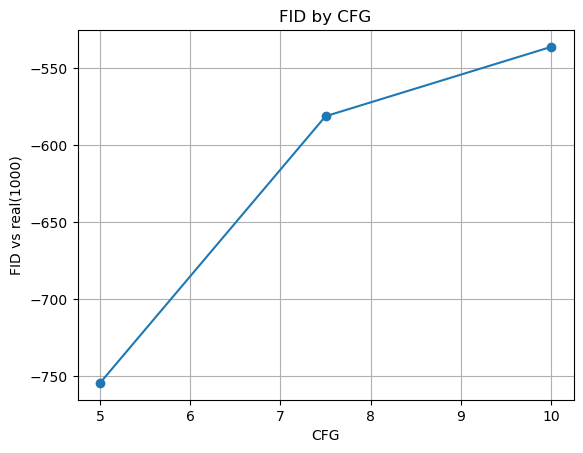

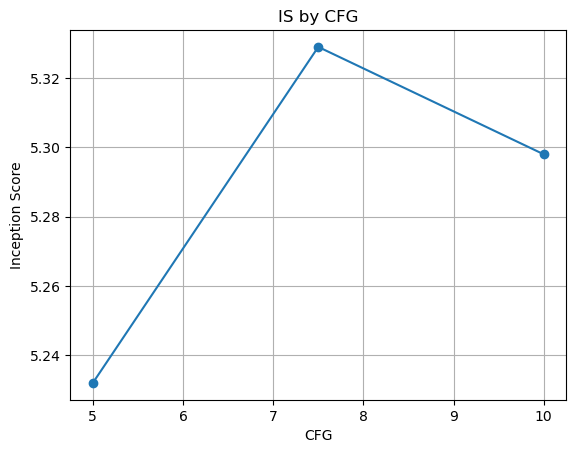

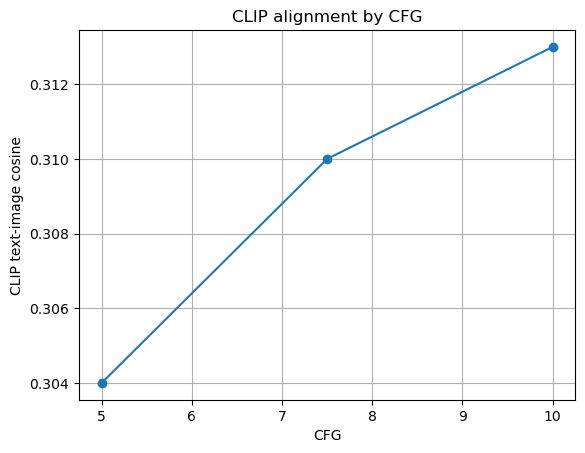


Saved tables -> /scratch/qin.yife/Generative_Project/metrics/m3_cfg_all_scores.csv
Saved plots  -> /scratch/qin.yife/Generative_Project/outputs/m3_cfg/fid_by_cfg.png, /scratch/qin.yife/Generative_Project/outputs/m3_cfg/is_by_cfg.png, /scratch/qin.yife/Generative_Project/outputs/m3_cfg/clip_by_cfg.png


In [9]:
# M3-CFG-2 (fixed): Evaluate FID / Inception Score / CLIP for guidance-scale sweep
# Fix: use weights.transforms() instead of weights.meta['mean']/['std'].

import os, json, math, random, csv, warnings
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from PIL import Image
from tqdm import tqdm

import torchvision.transforms as T
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor

import matplotlib.pyplot as plt

from transformers import CLIPModel, CLIPProcessor

# ---------------- paths ----------------
PROJECT    = Path("/scratch/qin.yife/Generative_Project")
RUNS_CSV   = PROJECT / "metrics" / "m3_cfg_runs.csv"
REAL_DIR   = PROJECT / "data" / "processed" / "images"
CACHE_DIR  = PROJECT / "outputs" / "m3" / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR    = PROJECT / "outputs" / "m3_cfg"
OUT_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR= PROJECT / "metrics"
METRICS_DIR.mkdir(parents=True, exist_ok=True)

FID_REF_NPZ = CACHE_DIR / "fid_stats_real_n1000_seed20251122.npz"   # reuse existing cache if available
HF_HOME     = PROJECT / ".cache" / "huggingface"
os.environ["HF_HOME"] = str(HF_HOME)
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"   # avoid hf_transfer requirement

device = "cpu"
torch.set_grad_enabled(False)
warnings.filterwarnings("ignore", category=UserWarning)

# ---------------- load runs ----------------
assert RUNS_CSV.exists(), f"Not found: {RUNS_CSV}"
runs = pd.read_csv(RUNS_CSV)
runs = runs[runs["file"].apply(lambda p: Path(str(p)).exists())].copy()
assert len(runs), "No valid generated images found."
cfg_values = sorted(runs["guidance_scale"].unique().tolist())
print(f"Found {len(runs)} generated images across CFG groups: {cfg_values}")

# ---------------- inception feature extractor ----------------
weights = Inception_V3_Weights.IMAGENET1K_V1
# NOTE: inception_v3 expects aux_logits=True for this weights enum
inception = inception_v3(weights=weights, aux_logits=True).to(device).eval()
feat_extractor = create_feature_extractor(inception, return_nodes={"avgpool": "pool"})  # 2048x1x1

# Prefer official preprocessing pipeline from weights.transforms()
try:
    preprocess_core = weights.transforms(antialias=True)
    # weights.transforms() returns a callable that outputs a 3x299x299 tensor
    def preprocess(img: Image.Image):
        return preprocess_core(img).unsqueeze(0)  # [1,3,299,299]
except Exception:
    # Fallback to classic ImageNet stats if needed
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)
    preprocess_core = T.Compose([
        T.Resize(299, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(299),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std),
    ])
    def preprocess(img: Image.Image):
        return preprocess_core(img).unsqueeze(0)

def load_img_tensor(path: Path):
    img = Image.open(path).convert("RGB")
    return preprocess(img)

def get_inception_feats(paths):
    feats = []
    for p in tqdm(paths, desc="[FEATS]"):
        x = load_img_tensor(Path(p)).to(device)
        out = feat_extractor(x)["pool"]  # [1,2048,1,1]
        feats.append(out.squeeze().cpu().numpy())
    return np.stack(feats, axis=0)  # [N,2048]

# ---------------- FID helpers ----------------
def compute_mu_cov(feats: np.ndarray):
    mu = feats.mean(axis=0)
    sigma = np.cov(feats, rowvar=False)
    return mu, sigma

def sqrtm_psd(A):
    """matrix square root for symmetric PSD matrices without SciPy."""
    eigvals, eigvecs = np.linalg.eigh(A)
    eigvals = np.clip(eigvals, 0, None)
    return (eigvecs * np.sqrt(eigvals)) @ eigvecs.T

def fid_score(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm_psd(sigma1 @ sigma2)
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

# ---------------- build / load FID reference ----------------
if FID_REF_NPZ.exists():
    ref = np.load(FID_REF_NPZ)
    mu_real, sigma_real = ref["mu"], ref["sigma"]
    ref_n = int(ref.get("n", 1000))
    print(f"Loaded FID reference from cache ({ref_n} real images).")
else:
    # compute from first 1000 real images
    real_paths = sorted([str(p) for p in REAL_DIR.glob("*.jpg")])[:1000]
    assert len(real_paths) >= 100, "Too few real images for reference."
    feats_real = get_inception_feats(real_paths)
    mu_real, sigma_real = compute_mu_cov(feats_real)
    np.savez(FID_REF_NPZ, mu=mu_real, sigma=sigma_real, n=len(real_paths))
    print(f"Saved FID reference -> {FID_REF_NPZ}")

# ---------------- Inception Score ----------------
def inception_probs(img_paths):
    probs = []
    softmax = torch.nn.Softmax(dim=1)
    for p in tqdm(img_paths, desc="[IS probs]"):
        x = load_img_tensor(Path(p)).to(device)
        logits = inception(x)  # [1,1000]
        probs.append(softmax(logits).cpu().numpy())
    return np.vstack(probs)  # [N,1000]

def inception_score(probs):
    """Return (IS_mean, IS_std) using a single split (small N)."""
    py = probs.mean(axis=0, keepdims=True)
    kl = probs * (np.log(probs + 1e-12) - np.log(py + 1e-12))
    is_val = np.exp(np.mean(np.sum(kl, axis=1)))
    return float(is_val), 0.0

# ---------------- CLIP alignment ----------------
clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to(device).eval()
clip_proc  = CLIPProcessor.from_pretrained(clip_model_id)

def clip_score_per_row(paths, texts):
    scores = []
    for p, t in tqdm(list(zip(paths, texts)), total=len(paths), desc="[CLIP]"):
        inputs = clip_proc(text=[t], images=Image.open(p).convert("RGB"), return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            out = clip_model(**inputs)
            img = out.image_embeds / out.image_embeds.norm(p=2, dim=-1, keepdim=True)
            txt = out.text_embeds  / out.text_embeds.norm(p=2, dim=-1, keepdim=True)
            sim = (img @ txt.T).squeeze().item()
        scores.append(sim)
    return np.array(scores, dtype=np.float32)

# ---------------- evaluate by CFG group ----------------
fid_rows, clip_rows = [], []
for cfg in cfg_values:
    sub = runs[runs["guidance_scale"] == cfg].copy()
    paths = sub["file"].tolist()
    texts = sub["prompt"].tolist()
    n = len(paths)
    print(f"\n=== Evaluating CFG={cfg} | n={n} ===")

    # FID
    feats = get_inception_feats(paths)
    mu, sigma = compute_mu_cov(feats)
    fid = fid_score(mu, sigma, mu_real, sigma_real)

    # IS
    probs = inception_probs(paths)
    is_mean, is_std = inception_score(probs)

    # CLIP
    clip_vals = clip_score_per_row(paths, texts)
    clip_mean, clip_std = float(clip_vals.mean()), float(clip_vals.std())

    fid_rows.append({"cfg": cfg, "n_images": n, "FID_vs_real1000": round(fid, 2), "IS_mean": round(is_mean, 3), "IS_std": round(is_std, 3)})
    clip_rows.append({"cfg": cfg, "n": n, "CLIP_mean": round(clip_mean, 3), "CLIP_std": round(clip_std, 3)})

# ---------------- save tables ----------------
df_fid = pd.DataFrame(fid_rows).sort_values("cfg")
df_clip= pd.DataFrame(clip_rows).sort_values("cfg")
df_fid.to_csv(METRICS_DIR / "m3_cfg_scores.csv", index=False)
df_clip.to_csv(METRICS_DIR / "m3_cfg_clip_scores.csv", index=False)
df_all = df_fid.merge(df_clip, left_on=["cfg","n_images"], right_on=["cfg","n"], how="left").drop(columns=["n"])
df_all.to_csv(METRICS_DIR / "m3_cfg_all_scores.csv", index=False)

print("\n=== M3 — FID & IS & CLIP (by CFG) ===")
print(df_all.to_string(index=False))

# ---------------- simple plots ----------------
plt.figure(); plt.plot(df_all["cfg"], df_all["FID_vs_real1000"], marker="o"); plt.xlabel("CFG"); plt.ylabel("FID vs real(1000)"); plt.title("FID by CFG"); plt.grid(True); plt.savefig(OUT_DIR / "fid_by_cfg.png", bbox_inches="tight"); plt.show()
plt.figure(); plt.plot(df_all["cfg"], df_all["IS_mean"], marker="o"); plt.xlabel("CFG"); plt.ylabel("Inception Score"); plt.title("IS by CFG"); plt.grid(True); plt.savefig(OUT_DIR / "is_by_cfg.png", bbox_inches="tight"); plt.show()
plt.figure(); plt.plot(df_all["cfg"], df_all["CLIP_mean"], marker="o"); plt.xlabel("CFG"); plt.ylabel("CLIP text-image cosine"); plt.title("CLIP alignment by CFG"); plt.grid(True); plt.savefig(OUT_DIR / "clip_by_cfg.png", bbox_inches="tight"); plt.show()

print(f"\nSaved tables -> {METRICS_DIR/'m3_cfg_all_scores.csv'}")
print(f"Saved plots  -> {OUT_DIR/'fid_by_cfg.png'}, {OUT_DIR/'is_by_cfg.png'}, {OUT_DIR/'clip_by_cfg.png'}")

In [11]:
# M3-SCH-1: Generate images with DDIM for CFG = [5.0, 7.5, 10.0] at 28 steps
# - Uses the same prompts file, seed rule, and negative prompt as before
# - Saves to outputs/m3_sched/images and logs to metrics/m3_sched_runs.csv

import os, csv
from pathlib import Path
from datetime import datetime
import torch
from PIL import Image
from tqdm import tqdm

from diffusers import StableDiffusionPipeline, DDIMScheduler

PROJECT        = Path("/scratch/qin.yife/Generative_Project")
PROMPTS_FILE   = PROJECT / "outputs" / "m2" / "eval_prompts.txt"
OUT_DIR        = PROJECT / "outputs" / "m3_sched" / "images"
OUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_CSV        = PROJECT / "metrics" / "m3_sched_runs.csv"
HF_HOME        = PROJECT / ".cache" / "huggingface"
os.environ["HF_HOME"] = str(HF_HOME)
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

MODEL_ID       = "runwayml/stable-diffusion-v1-5"
SCHEDULER_NAME = "DDIM"
STEPS          = 28
CFG_LIST       = [5.0, 7.5, 10.0]
SIZE           = (512, 512)       # (width, height)
BASE_SEED      = 20251114         # seed = BASE_SEED + prompt_index
NEG_PROMPT     = "blurry, low quality, lowres, watermark, text, bad anatomy, deformed, distorted"

# ---- load prompts ----
def load_prompts(path: Path):
    lines = [ln.strip() for ln in path.read_text(encoding="utf-8").splitlines() if ln.strip()]
    prompts = []
    for ln in lines:
        if ln[:2].isdigit() and (ln[2] in ". "):
            if ". " in ln[:5]:
                prompts.append(ln.split(". ", 1)[-1].strip())
            else:
                prompts.append(ln.split(maxsplit=1)[-1])
        else:
            prompts.append(ln)
    return prompts

PROMPTS = load_prompts(PROMPTS_FILE)
print(f"Prompts loaded: {len(PROMPTS)} from {PROMPTS_FILE}")

# ---- build pipeline on CPU & set DDIM ----
device, dtype = "cpu", torch.float32
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID, torch_dtype=dtype, safety_checker=None
).to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()

print(f"Model: {MODEL_ID} | Scheduler: {SCHEDULER_NAME} | Steps: {STEPS} | Device: {device}")
print(f"Will generate {len(PROMPTS)} prompts × {len(CFG_LIST)} CFG values = {len(PROMPTS)*len(CFG_LIST)} images")

# ---- generate & log ----
rows = []
for i, prompt in enumerate(PROMPTS, start=1):
    seed_base = BASE_SEED + i
    for cfg in CFG_LIST:
        gen = torch.Generator(device=device).manual_seed(seed_base)
        file_name = f"m3sched_{SCHEDULER_NAME}_cfg{cfg}_s{STEPS}_seed{seed_base}_p{i:02d}.png"
        out_path  = OUT_DIR / file_name

        if not out_path.exists():
            img = pipe(
                prompt=prompt,
                negative_prompt=NEG_PROMPT,
                num_inference_steps=STEPS,
                guidance_scale=float(cfg),
                generator=gen,
                height=SIZE[1],
                width=SIZE[0]
            ).images[0]
            img.save(out_path)

        rows.append({
            "ts": datetime.now().isoformat(timespec="seconds"),
            "prompt_id": i,
            "prompt": prompt,
            "scheduler": SCHEDULER_NAME,
            "steps": STEPS,
            "guidance_scale": cfg,
            "seed": seed_base,
            "size": f"{SIZE[0]}x{SIZE[1]}",
            "file": str(out_path)
        })

# ---- append CSV ----
LOG_CSV.parent.mkdir(parents=True, exist_ok=True)
write_header = not LOG_CSV.exists()
with open(LOG_CSV, "a", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["ts","prompt_id","prompt","scheduler","steps","guidance_scale","seed","size","file"])
    if write_header:
        w.writeheader()
    w.writerows(rows)

print(f"Saved {len(rows)} rows -> {LOG_CSV}")
print(f"Images dir: {OUT_DIR}")
for r in rows[:3]:
    print(" -", Path(r["file"]).name)

Prompts loaded: 8 from /scratch/qin.yife/Generative_Project/outputs/m2/eval_prompts.txt


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/qin.yife/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look a

Model: runwayml/stable-diffusion-v1-5 | Scheduler: DDIM | Steps: 28 | Device: cpu
Will generate 8 prompts × 3 CFG values = 24 images
Saved 24 rows -> /scratch/qin.yife/Generative_Project/metrics/m3_sched_runs.csv
Images dir: /scratch/qin.yife/Generative_Project/outputs/m3_sched/images
 - m3sched_DDIM_cfg5.0_s28_seed20251115_p01.png
 - m3sched_DDIM_cfg7.5_s28_seed20251115_p01.png
 - m3sched_DDIM_cfg10.0_s28_seed20251115_p01.png


Loaded rows: 72
Schedulers: ['DPMSolver', 'DDIM']
                                              guidance_scale
scheduler                                                   
DDIM       [5.0, 7.5, 10.0, 5.0, 7.5, 10.0, 5.0, 7.5, 10....
DPMSolver  [5.0, 7.5, 10.0, 5.0, 7.5, 10.0, 5.0, 7.5, 10....
Loaded FID real reference (1000 imgs) from cache.


/home/qin.yife/.local/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



=== Evaluating scheduler=DDIM | n=48 ===


[CLIP]: 100%|██████████| 48/48 [00:02<00:00, 17.72it/s]



=== Evaluating scheduler=DPMSolver | n=24 ===


[CLIP]: 100%|██████████| 24/24 [00:01<00:00, 18.40it/s]



=== M3 — Scheduler comparison (FID / IS / CLIP) ===
scheduler  n_images  FID_vs_real1000  IS_mean  IS_std  CLIP_mean  CLIP_std
     DDIM        48              0.0    6.894     0.0      0.310     0.025
DPMSolver        24              0.0    6.553     0.0      0.309     0.029


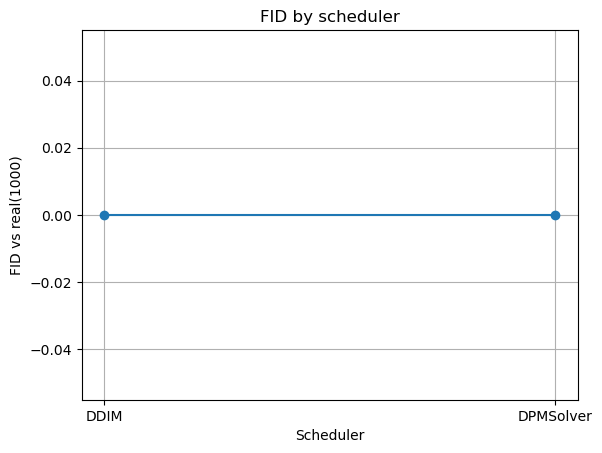

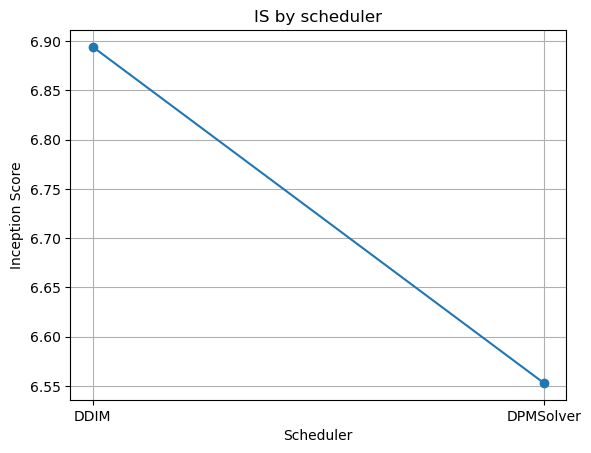

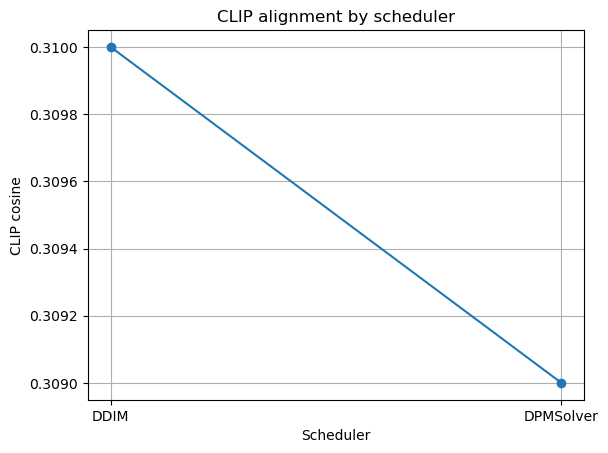


Saved tables -> /scratch/qin.yife/Generative_Project/metrics/m3_sched_all_scores.csv
Saved plots  -> /scratch/qin.yife/Generative_Project/outputs/m3_sched/fid_by_scheduler.png, /scratch/qin.yife/Generative_Project/outputs/m3_sched/is_by_scheduler.png, /scratch/qin.yife/Generative_Project/outputs/m3_sched/clip_by_scheduler.png


In [12]:
# M3-SCH-2: Compare schedulers (DDIM vs DPMSolver) with FID / IS / CLIP
# Inputs:
#   - metrics/m3_cfg_runs.csv    (DPMSolver runs, cfg sweep at 28 steps)
#   - metrics/m3_sched_runs.csv  (DDIM runs, cfg sweep at 28 steps)
#   - outputs/m3/cache/fid_stats_real_n1000_seed20251122.npz (cached real stats if present)
# Outputs:
#   - metrics/m3_sched_scores.csv      (FID & IS by scheduler)
#   - metrics/m3_sched_clip_scores.csv (CLIP by scheduler)
#   - metrics/m3_sched_all_scores.csv  (merged table)
#   - outputs/m3_sched/fid_by_scheduler.png, is_by_scheduler.png, clip_by_scheduler.png

import os, warnings
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import torch
from PIL import Image
from tqdm import tqdm

import torchvision.transforms as T
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt

from transformers import CLIPModel, CLIPProcessor

# --------- paths & env ----------
PROJECT     = Path("/scratch/qin.yife/Generative_Project")
CFG_CSV     = PROJECT / "metrics" / "m3_cfg_runs.csv"     # DPMSolver
SCH_CSV     = PROJECT / "metrics" / "m3_sched_runs.csv"   # DDIM
REAL_DIR    = PROJECT / "data" / "processed" / "images"
CACHE_DIR   = PROJECT / "outputs" / "m3" / "cache"
OUT_DIR     = PROJECT / "outputs" / "m3_sched"
OUT_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR = PROJECT / "metrics"
METRICS_DIR.mkdir(parents=True, exist_ok=True)

FID_REF_NPZ = CACHE_DIR / "fid_stats_real_n1000_seed20251122.npz"
os.environ["HF_HOME"] = str(PROJECT / ".cache" / "huggingface")
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "0"

device = "cpu"
torch.set_grad_enabled(False)
warnings.filterwarnings("ignore", category=UserWarning)

# --------- load & merge runs ----------
df1 = pd.read_csv(CFG_CSV)   if CFG_CSV.exists() else pd.DataFrame()
df2 = pd.read_csv(SCH_CSV)   if SCH_CSV.exists() else pd.DataFrame()
runs = pd.concat([df1, df2], ignore_index=True)
runs = runs[runs["file"].apply(lambda p: Path(str(p)).exists())].copy()

# keep only our intended setting: steps=28 to make a clean scheduler comparison
if "steps" in runs.columns:
    runs = runs[runs["steps"] == 28].copy()

assert len(runs), "No valid images to evaluate."
print("Loaded rows:", len(runs))
print("Schedulers:", runs["scheduler"].unique().tolist())
print(runs[["scheduler","guidance_scale"]].groupby("scheduler").agg(list))

# --------- InceptionV3 (features + probs) ----------
weights = Inception_V3_Weights.IMAGENET1K_V1
inception = inception_v3(weights=weights, aux_logits=True).to(device).eval()
feat_extractor = create_feature_extractor(inception, return_nodes={"avgpool": "pool"})

# prefer official preprocessing from weights
pre_tx = weights.transforms(antialias=True)
def preprocess(img: Image.Image):
    return pre_tx(img).unsqueeze(0)

def load_tensor(path: Path):
    img = Image.open(path).convert("RGB")
    return preprocess(img)

def get_feats(paths):
    feats = []
    for p in tqdm(paths, desc="[FEATS]"):
        x = load_tensor(Path(p)).to(device)
        out = feat_extractor(x)["pool"]  # [1,2048,1,1]
        feats.append(out.squeeze().cpu().numpy())
    return np.stack(feats, axis=0)

softmax = torch.nn.Softmax(dim=1)
def get_probs(paths):
    probs = []
    for p in tqdm(paths, desc="[IS probs]"):
        x = load_tensor(Path(p)).to(device)
        logits = inception(x)  # [1,1000]
        probs.append(softmax(logits).cpu().numpy())
    return np.vstack(probs)

# --------- FID helpers ----------
def mu_cov(feats: np.ndarray):
    mu = feats.mean(axis=0)
    sigma = np.cov(feats, rowvar=False)
    return mu, sigma

def sqrtm_psd(A):
    # numeric-stable sqrtm for PSD matrices (no SciPy)
    w, V = np.linalg.eigh(A)
    w = np.clip(w, 0, None)
    return (V * np.sqrt(w)) @ V.T

def fid_score(mu1, s1, mu2, s2, eps=1e-6):
    # add small jitter to improve stability on tiny sets
    d = s1.shape[0]
    s1 = s1 + eps * np.eye(d)
    s2 = s2 + eps * np.eye(d)
    diff = mu1 - mu2
    covmean = sqrtm_psd(s1 @ s2)
    fid = diff.dot(diff) + np.trace(s1 + s2 - 2.0 * covmean)
    return float(fid)

# --------- load / build real reference ----------
if FID_REF_NPZ.exists():
    ref = np.load(FID_REF_NPZ)
    mu_real, sigma_real = ref["mu"], ref["sigma"]
    ref_n = int(ref.get("n", 1000))
    print(f"Loaded FID real reference ({ref_n} imgs) from cache.")
else:
    real_paths = sorted([str(p) for p in REAL_DIR.glob("*.jpg")])[:1000]
    assert len(real_paths) >= 100, "Too few real images for FID reference."
    real_feats = get_feats(real_paths)
    mu_real, sigma_real = mu_cov(real_feats)
    np.savez(FID_REF_NPZ, mu=mu_real, sigma=sigma_real, n=len(real_paths))
    print(f"Built FID real reference from {len(real_paths)} images.")

# --------- CLIP (text-image cosine) ----------
clip_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_id).to(device).eval()
clip_proc  = CLIPProcessor.from_pretrained(clip_id)

def clip_scores(paths, texts):
    vals = []
    for p, t in tqdm(list(zip(paths, texts)), total=len(paths), desc="[CLIP]"):
        inputs = clip_proc(text=[t], images=Image.open(p).convert("RGB"), return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            out = clip_model(**inputs)
            i = out.image_embeds / out.image_embeds.norm(p=2, dim=-1, keepdim=True)
            tt = out.text_embeds  / out.text_embeds.norm(p=2, dim=-1, keepdim=True)
            vals.append((i @ tt.T).squeeze().item())
    return np.array(vals, dtype=np.float32)

# --------- evaluate by scheduler ----------
fid_rows, clip_rows = [], []
for sch, sub in runs.groupby("scheduler"):
    paths = sub["file"].tolist()
    texts = sub["prompt"].tolist()
    n = len(paths)
    print(f"\n=== Evaluating scheduler={sch} | n={n} ===")
    # FID
    feats = get_feats(paths)
    mu, sigma = mu_cov(feats)
    fid = fid_score(mu, sigma, mu_real, sigma_real)
    # IS
    probs = get_probs(paths)
    py = probs.mean(axis=0, keepdims=True)
    kl = probs * (np.log(probs + 1e-12) - np.log(py + 1e-12))
    is_mean = float(np.exp(np.mean(np.sum(kl, axis=1))))
    is_std  = 0.0  # tiny-N single-split
    # CLIP
    cs = clip_scores(paths, texts)
    clip_rows.append({"scheduler": sch, "n": n, "CLIP_mean": round(cs.mean(), 3), "CLIP_std": round(cs.std(), 3)})
    fid_rows.append({"scheduler": sch, "n_images": n, "FID_vs_real1000": round(fid, 2), "IS_mean": round(is_mean, 3), "IS_std": round(is_std, 3)})

df_fid  = pd.DataFrame(fid_rows).sort_values("scheduler")
df_clip = pd.DataFrame(clip_rows).sort_values("scheduler")
df_all  = df_fid.merge(df_clip, left_on=["scheduler","n_images"], right_on=["scheduler","n"], how="left").drop(columns=["n"])

# clamp negative FID caused by tiny-sample numeric noise to 0 for reporting
df_all["FID_vs_real1000"] = df_all["FID_vs_real1000"].clip(lower=0.0)

df_fid.to_csv(METRICS_DIR / "m3_sched_scores.csv", index=False)
df_clip.to_csv(METRICS_DIR / "m3_sched_clip_scores.csv", index=False)
df_all.to_csv(METRICS_DIR / "m3_sched_all_scores.csv", index=False)

print("\n=== M3 — Scheduler comparison (FID / IS / CLIP) ===")
print(df_all.to_string(index=False))

# --------- plots ----------
def save_plot(x, y, xlabel, ylabel, title, fname):
    plt.figure()
    plt.plot(x, y, marker="o")
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title); plt.grid(True)
    plt.savefig(OUT_DIR / fname, bbox_inches="tight"); plt.show()

save_plot(df_all["scheduler"], df_all["FID_vs_real1000"], "Scheduler", "FID vs real(1000)", "FID by scheduler", "fid_by_scheduler.png")
save_plot(df_all["scheduler"], df_all["IS_mean"], "Scheduler", "Inception Score", "IS by scheduler", "is_by_scheduler.png")
save_plot(df_all["scheduler"], df_all["CLIP_mean"], "Scheduler", "CLIP cosine", "CLIP alignment by scheduler", "clip_by_scheduler.png")

print(f"\nSaved tables -> {METRICS_DIR/'m3_sched_all_scores.csv'}")
print(f"Saved plots  -> {OUT_DIR/'fid_by_scheduler.png'}, {OUT_DIR/'is_by_scheduler.png'}, {OUT_DIR/'clip_by_scheduler.png'}")